#Install Packages

In [1]:
!apt-get install -y -qq glpk-utils
!pip install pulp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pulp import LpProblem, LpVariable, lpSum, LpMaximize, LpStatus, GLPK
from tabulate import tabulate

Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.10.1+dfsg-4build1_amd64.deb ...
Unpacking libcolamd2:amd64 (1:5.10.1+dfsg-4build1) ...
Selecting previously unselected package libglpk40:amd64.
Preparing to unpack .../libglpk40_5.0-1_amd64.deb ...
Unpacking libglpk40:amd64 (5.0-1) ...
Selecting previously unselected package glpk-utils.
Preparing to unpack .../glpk-utils_5.0-1_amd64.deb ...
Unpacking glpk-utils (5.0-1) ...
Setting up libsuitesparseconfig5:amd64 (1:5.10.1+dfsg-4b

#Load Data

In [2]:
print("--- Loading and Preparing Data ---")
try:
    url = 'https://raw.githubusercontent.com/PhuphaB/Dissertation/main/ESPN_Top_40_Players.csv'
    data = pd.read_csv(url, skiprows=[0])
    data.columns = [
        'ESPN_Ranking', 'Player', 'Team', 'Team_IG_Followers_M', 'PER', 'Minutes_Played',
        'Clutch_PPG', 'Win_Shares', 'True_Shooting_Pct', 'IG_Growth_Pct',
        'IG_Engagement_Pct', 'Player_IG_Followers_M', 'Google_Trends_Score', 'All_Star_Votes_M'
    ]
    data.replace(0, 0.00001, inplace=True)
    print("Data loaded and prepared successfully.\n")
except Exception as e:
    print(f"Fatal: Could not load data. Error: {e}")
    exit()

data.head(10)

--- Loading and Preparing Data ---
Data loaded and prepared successfully.



,ESPN_Ranking,Player,Team,Team_IG_Followers_M,PER,Minutes_Played,Clutch_PPG,Win_Shares,True_Shooting_Pct,IG_Growth_Pct,IG_Engagement_Pct,Player_IG_Followers_M,Google_Trends_Score,All_Star_Votes_M
0,2,Luka Doncic,Los Angeles Lakers,25.32,24.1,1769,1.9,5.9,58.7,24.00000,7.12,10.49,5.58,2.03
1,3,Giannis Antetokounmpo,Milwaukee Bucks,5.50,30.5,2289,2.9,11.5,62.5,1.26000,1.79,15.99,32.74,4.44
2,4,Shai Gilgeous-Alexander,Oklahoma City Thunder,6.16,30.7,2598,3.0,16.7,63.7,69.19000,10.73,4.01,41.52,3.15
3,5,Jayson Tatum,Boston Celtics,8.46,21.7,2624,3.0,9.5,58.2,10.60000,5.22,7.30,32.02,3.61
4,6,Stephen Curry,Golden State Warriors,32.72,21.5,2252,3.6,7.9,61.8,6.20000,0.77,58.11,29.29,2.34
5,7,Lebron James,Los Angeles Lakers,25.32,22.7,2444,2.6,7.7,60.4,0.70000,0.82,159.82,24.56,3.34
6,8,Joel Embiid,Philadelphia 76ers,4.51,23.4,574,2.1,1.4,58.0,0.00001,2.06,7.44,14.15,0.50
7,9,Kevin Durant,Phoenix Suns,3.66,21.2,2265,3.1,5.2,64.2,2.84000,6.76,13.76,43.16,3.17
8,10,Anthony Edwards,Minnesota Timberwolves,4.12,20.1,2871,3.7,8.4,59.5,203.29000,4.52,4.61,43.67,1.22
9,11,Victor Wembenyama,San Antonio Spurs,5.34,24.2,1527,2.5,3.8,59.4,75.00000,16.77,4.48,19.14,2.88


 # Define the Core DEA and Cross-Efficiency Functions

In [3]:
def run_dea(inputs_df, outputs_df, ar_constraint=False, return_weights=False, ar_lower_bound=0.05):
    """The foundational DEA engine for all calculations."""
    inputs = inputs_df.values
    outputs = outputs_df.values
    player_names = data['Player'].values
    num_players = len(player_names)
    num_inputs = inputs.shape[1]
    num_outputs = outputs.shape[1]
    efficiency_scores = {}
    optimal_weights = {}

    for i in range(num_players):
        prob = LpProblem(f"DEA_Player_{i}", LpMaximize)
        u = [LpVariable(f"u_{r}_{i}", lowBound=0) for r in range(num_outputs)]
        v = [LpVariable(f"v_{s}_{i}", lowBound=0) for s in range(num_inputs)]
        prob += lpSum(u[r] * outputs[i, r] for r in range(num_outputs))
        prob += lpSum(v[s] * inputs[i, s] for s in range(num_inputs)) == 1
        for j in range(num_players):
            prob += lpSum(u[r] * outputs[j, r] for r in range(num_outputs)) - \
                    lpSum(v[s] * inputs[j, s] for s in range(num_inputs)) <= 0
        if ar_constraint:
            sum_of_u_weights = lpSum(u)
            for r in range(num_outputs):
                prob += u[r] >= ar_lower_bound * sum_of_u_weights
        prob.solve(GLPK(msg=False))
        if LpStatus[prob.status] == 'Optimal':
            efficiency_scores[player_names[i]] = prob.objective.value()
            if return_weights:
                optimal_weights[player_names[i]] = {'u': [var.value() for var in u], 'v': [var.value() for var in v]}
        else:
            efficiency_scores[player_names[i]] = None
            if return_weights: optimal_weights[player_names[i]] = None
    results_df = pd.DataFrame(list(efficiency_scores.items()), columns=['Player', 'Efficiency_Score'])
    if return_weights:
        return results_df, optimal_weights
    else:
        return results_df

def calculate_cross_efficiency(inputs_df, outputs_df, all_weights):
    """Calculates the cross-efficiency matrix and final average scores."""
    inputs = inputs_df.values
    outputs = outputs_df.values
    player_names = data['Player'].values
    num_players = len(player_names)
    cross_efficiency_matrix = np.zeros((num_players, num_players))
    for i, i_player_name in enumerate(player_names):
        weights = all_weights[i_player_name]
        if weights is None: continue
        evaluator_u, evaluator_v = weights['u'], weights['v']
        for j, j_player_name in enumerate(player_names):
            weighted_outputs = np.sum(outputs[j, :] * evaluator_u)
            weighted_inputs = np.sum(inputs[j, :] * evaluator_v)
            score = weighted_outputs / weighted_inputs if weighted_inputs != 0 else 0
            cross_efficiency_matrix[i, j] = score
    final_cross_scores = np.mean(cross_efficiency_matrix, axis=0)
    scores_df = pd.DataFrame({'Player': player_names, 'Cross_Efficiency_Score': final_cross_scores})
    return scores_df

In [4]:
# Define the inputs and outputs for the model
input_cols = ['PER', 'Win_Shares', 'Minutes_Played', 'True_Shooting_Pct', 'Clutch_PPG', 'Team_IG_Followers_M']
output_cols = ['IG_Growth_Pct', 'IG_Engagement_Pct', 'Player_IG_Followers_M', 'All_Star_Votes_M', 'Google_Trends_Score']
model1_inputs = data[input_cols]
model1_outputs = data[output_cols]

# MODEL 1 ANALYSIS (WITHOUT AR CONSTRAINT)

In [5]:
# Run standard DEA and store scores and weights
model1_no_ar_scores, model1_no_ar_weights = run_dea(model1_inputs, model1_outputs, ar_constraint=False, return_weights=True)
print("\n--- Results: Model 1 ---")
print(tabulate(model1_no_ar_scores, headers='keys', tablefmt='fancy_grid', showindex=False))
model1_no_ar_scores.to_csv('model_1_no_ar_standard_scores.csv', index=False)
print("Standard DEA scores and weights calculated and saved.")


--- Results: Model 1 ---
╒═════════════════════════╤════════════════════╕
│ Player                  │   Efficiency_Score │
╞═════════════════════════╪════════════════════╡
│ Luka Doncic             │           0.723999 │
├─────────────────────────┼────────────────────┤
│ Giannis Antetokounmpo   │           1        │
├─────────────────────────┼────────────────────┤
│ Shai Gilgeous-Alexander │           1        │
├─────────────────────────┼────────────────────┤
│ Jayson Tatum            │           1        │
├─────────────────────────┼────────────────────┤
│ Stephen Curry           │           0.834617 │
├─────────────────────────┼────────────────────┤
│ Lebron James            │           1        │
├─────────────────────────┼────────────────────┤
│ Joel Embiid             │           1        │
├─────────────────────────┼────────────────────┤
│ Kevin Durant            │           1        │
├─────────────────────────┼────────────────────┤
│ Anthony Edwards         │           1    

In [6]:
# Calculate cross-efficiency and final ranking
no_ar_cross_eff_scores = calculate_cross_efficiency(model1_inputs, model1_outputs, model1_no_ar_weights)
no_ar_cross_eff_scores['Rank'] = no_ar_cross_eff_scores['Cross_Efficiency_Score'].rank(method='min', ascending=False).astype(int)
no_ar_cross_eff_scores_sorted = no_ar_cross_eff_scores.sort_values(by='Rank')
no_ar_cross_eff_scores_sorted.to_csv('model_1_no_ar_cross_efficiency_ranking.csv', index=False)
print("Cross-efficiency ranking calculated and saved.")


Cross-efficiency ranking calculated and saved.


In [7]:
# Display the final ranked table
print("\n--- Final Cross-Efficiency Ranking (Model 1 without AR) ---")
print(tabulate(no_ar_cross_eff_scores_sorted, headers='keys', tablefmt='fancy_grid', showindex=False))


--- Final Cross-Efficiency Ranking (Model 1 without AR) ---
╒═════════════════════════╤══════════════════════════╤════════╕
│ Player                  │   Cross_Efficiency_Score │   Rank │
╞═════════════════════════╪══════════════════════════╪════════╡
│ Kevin Durant            │                0.835805  │      1 │
├─────────────────────────┼──────────────────────────┼────────┤
│ Victor Wembenyama       │                0.823995  │      2 │
├─────────────────────────┼──────────────────────────┼────────┤
│ Anthony Edwards         │                0.671559  │      3 │
├─────────────────────────┼──────────────────────────┼────────┤
│ Shai Gilgeous-Alexander │                0.658091  │      4 │
├─────────────────────────┼──────────────────────────┼────────┤
│ Karl-Anthony Towns      │                0.648133  │      5 │
├─────────────────────────┼──────────────────────────┼────────┤
│ Giannis Antetokounmpo   │                0.576047  │      6 │
├─────────────────────────┼────────────────

# PART B: MODEL 1 ANALYSIS (WITH AR CONSTRAINT)

In [8]:
# Run AR-constrained DEA and store scores and weights
model1_with_ar_scores, model1_with_ar_weights = run_dea(model1_inputs, model1_outputs, ar_constraint=True, return_weights=True)
model1_with_ar_scores.to_csv('model_1_with_ar_standard_scores.csv', index=False)
print("AR-constrained DEA scores and weights calculated and saved.")


AR-constrained DEA scores and weights calculated and saved.


In [9]:
# Calculate cross-efficiency and final ranking for the AR model
with_ar_cross_eff_scores = calculate_cross_efficiency(model1_inputs, model1_outputs, model1_with_ar_weights)
with_ar_cross_eff_scores['Rank'] = with_ar_cross_eff_scores['Cross_Efficiency_Score'].rank(method='min', ascending=False).astype(int)
with_ar_cross_eff_scores_sorted = with_ar_cross_eff_scores.sort_values(by='Rank')
with_ar_cross_eff_scores_sorted.to_csv('model_1_with_ar_cross_efficiency_ranking.csv', index=False)
print("Cross-efficiency ranking for AR model calculated and saved.")

Cross-efficiency ranking for AR model calculated and saved.


In [10]:
# Display the final ranked table for the AR model
print("\n--- Final Cross-Efficiency Ranking (Model 1 with AR) ---")
print(tabulate(with_ar_cross_eff_scores_sorted, headers='keys', tablefmt='fancy_grid', showindex=False))


--- Final Cross-Efficiency Ranking (Model 1 with AR) ---
╒═════════════════════════╤══════════════════════════╤════════╕
│ Player                  │   Cross_Efficiency_Score │   Rank │
╞═════════════════════════╪══════════════════════════╪════════╡
│ Anthony Edwards         │                0.959699  │      1 │
├─────────────────────────┼──────────────────────────┼────────┤
│ Victor Wembenyama       │                0.763712  │      2 │
├─────────────────────────┼──────────────────────────┼────────┤
│ Kevin Durant            │                0.738714  │      3 │
├─────────────────────────┼──────────────────────────┼────────┤
│ Jrue Holiday            │                0.688958  │      4 │
├─────────────────────────┼──────────────────────────┼────────┤
│ Kawhi Leonard           │                0.674047  │      5 │
├─────────────────────────┼──────────────────────────┼────────┤
│ Devin Booker            │                0.666761  │      6 │
├─────────────────────────┼───────────────────

# PART C: COMPARATIVE VISUALIZATION

In [11]:
# Load the two final ranking files we created
no_ar_ranks = pd.read_csv('model_1_no_ar_cross_efficiency_ranking.csv')
with_ar_ranks = pd.read_csv('model_1_with_ar_cross_efficiency_ranking.csv')

# Merge the two dataframes on the 'Player' column
# We rename the rank columns for clarity in the plot
comparison_df = pd.merge(
    no_ar_ranks[['Player', 'Rank']],
    with_ar_ranks[['Player', 'Rank']],
    on='Player',
    suffixes=('_No_AR', '_With_AR')
)

# Sort the data by the 'With AR' rank for a clean, ordered plot
comparison_df_sorted = comparison_df.sort_values(by='Rank_With_AR', ascending=False)


Dumbbell plot saved as 'model_1_ranking_comparison_dumbbell.png'


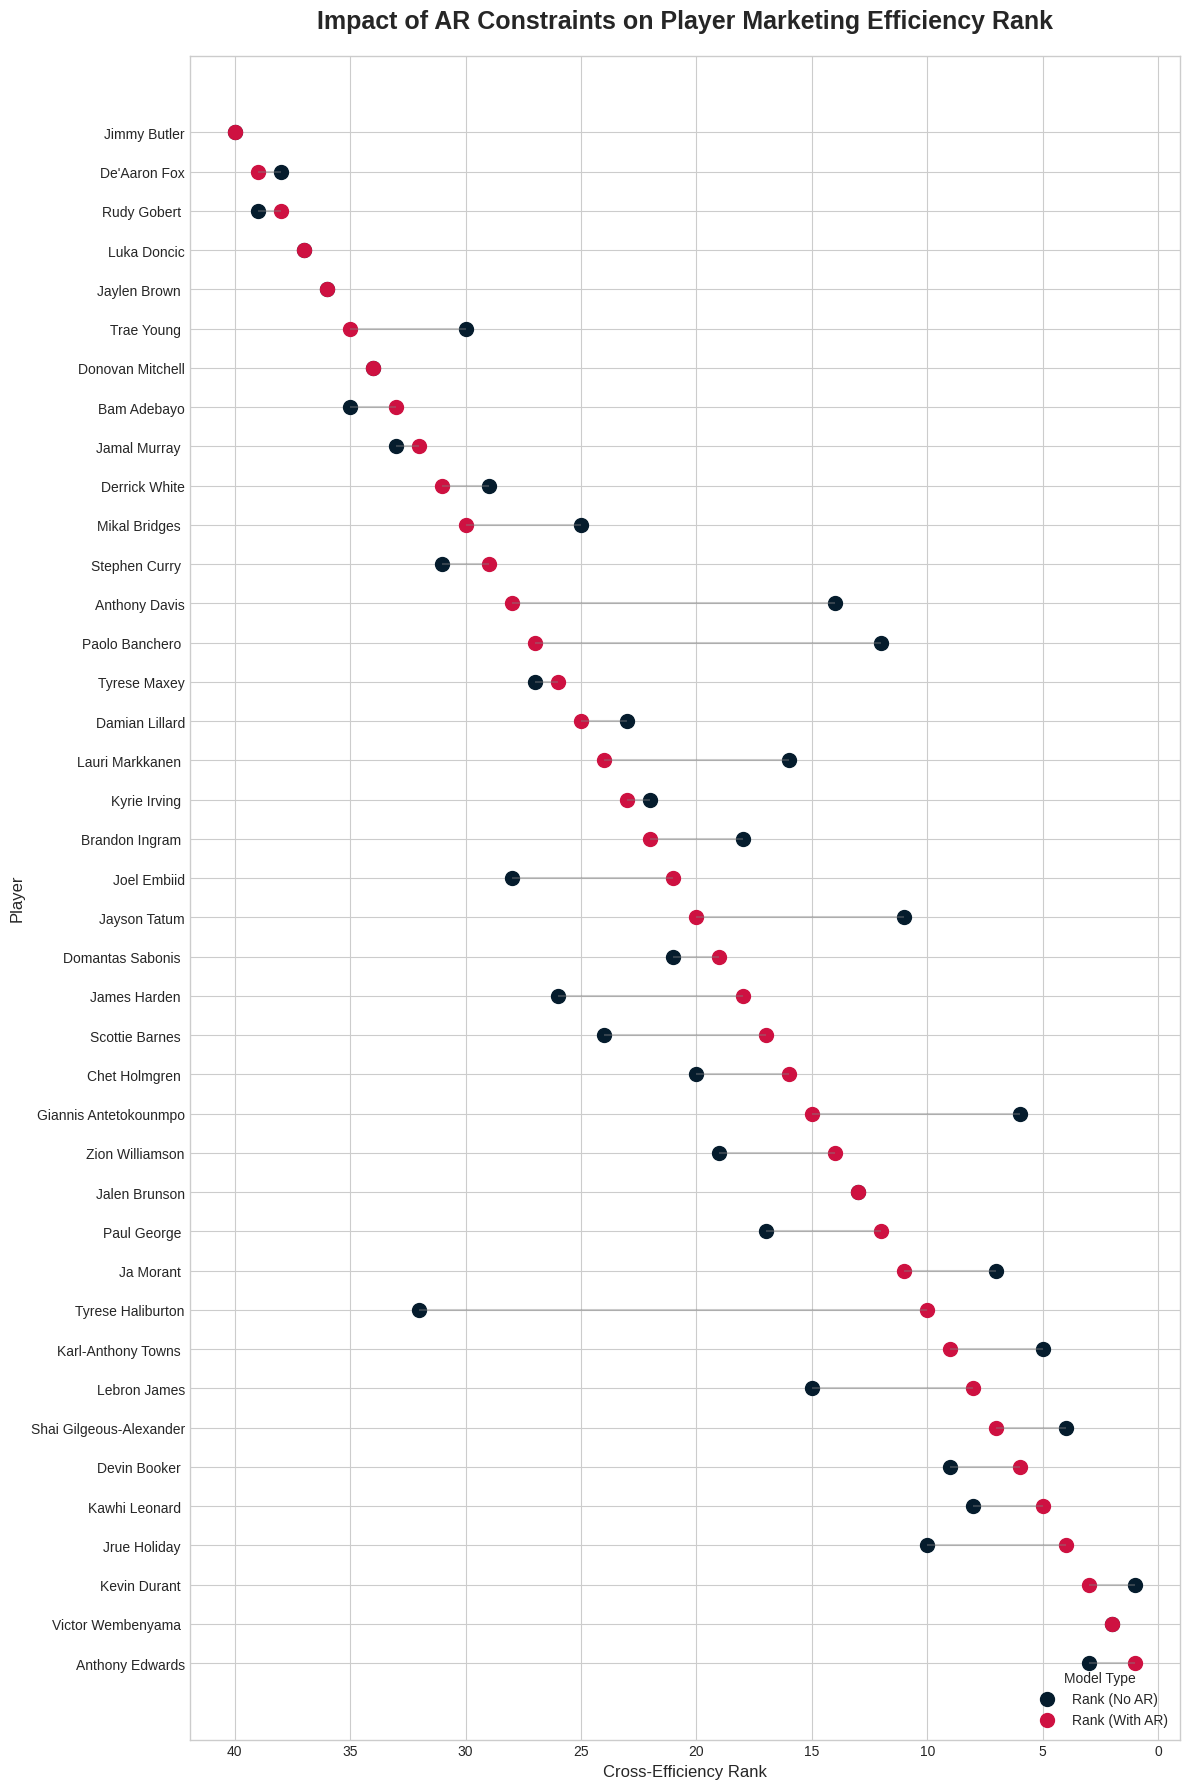

In [12]:
# --- Generate the Dumbbell Plot ---
import matplotlib.pyplot as plt

# Define the official NBA logo colors
nba_blue = '#051c2d'
nba_red = '#ce1141'

# Create the figure and axes for the plot
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 18))

# Draw the horizontal lines connecting the two rank points for each player
ax.hlines(
    y=comparison_df_sorted['Player'],
    xmin=comparison_df_sorted['Rank_No_AR'],
    xmax=comparison_df_sorted['Rank_With_AR'],
    color='grey',
    alpha=0.4
)

# Draw the scatter points for the 'No AR' and 'With AR' ranks
ax.scatter(comparison_df_sorted['Rank_No_AR'], comparison_df_sorted['Player'], color=nba_blue, s=100, label='Rank (No AR)')
ax.scatter(comparison_df_sorted['Rank_With_AR'], comparison_df_sorted['Player'], color=nba_red, s=100, label='Rank (With AR)')

# --- 3. Formatting and Labels ---
# Invert the x-axis because a lower rank is better
ax.invert_xaxis()

# Invert the y-axis to show the top-ranked player at the top
ax.invert_yaxis()

# Add the new, more descriptive title and labels
ax.set_title('Impact of AR Constraints on Player Marketing Efficiency Rank', fontsize=18, pad=20, weight='bold')
ax.set_xlabel('Cross-Efficiency Rank', fontsize=12)
ax.set_ylabel('Player', fontsize=12)
ax.legend(title='Model Type', loc='lower right')

# Ensure the layout is tight and save the figure
plt.tight_layout()
plt.savefig('model_1_ranking_comparison_dumbbell.png', dpi=300)
print("\nDumbbell plot saved as 'model_1_ranking_comparison_dumbbell.png'")
plt.show()